### Load them libraries...

In [14]:
library(phyloseq)
library(ggplot2)
library(vegan)
library(readr)
library(data.table)
library(dplyr)
library(stats)
library(ggpubr)
library(dunn.test)

#### Read in Sho original phyloseq object

In [93]:
#Non-transformed OTU counts
ps.nt = readRDS("/home/holutz/Temp/ShoKodera/phyloseq.rds") 

#### Introduce some modifications to original phyloseq object

In [ ]:
#Import phylogenetic information
tre = read_tree("/home/holutz/Temp/ShoKodera/study_tree.tree")

#Import modified metadata w numeric variables as factors
map = import_qiime_sample_data("/home/holutz/Temp/ShoKodera/phyloseq.sampledata.df.txt")

#breakdown ps.nt into components to create new phyloseq object
otu = otu_table(ps.nt)
tax = tax_table(ps.nt)

#create new phyloseq object by combining all of the above
ps.nt = merge_phyloseq(tre,map,otu,tax)

#Trasform OTUs for relative abundance within each library
ps.t = ps.nt %>%
    transform_sample_counts(function(x) x / sum(x))
                            
#Save new non-transformed and transformed phyloseq objects for subsequent analysis
saveRDS(ps.nt, "/home/holutz/Temp/ShoKodera/CAWS_nt.rds")
saveRDS(ps.t, "/home/holutz/Temp/ShoKodera/CAWS_t.rds")

### BEGIN ANALYSES HERE

In [94]:
#Read in phyloseq objects (ps)
ps.nt = readRDS("/home/holutz/Temp/ShoKodera/CAWS_nt.rds")
ps.t = readRDS("/home/holutz/Temp/ShoKodera/CAWS_t.rds")
#Display ps information
ps.t

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 50223 taxa and 832 samples ]
sample_data() Sample Data:       [ 832 samples by 42 sample variables ]
tax_table()   Taxonomy Table:    [ 50223 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 50223 tips and 50201 internal nodes ]

In [96]:
#Explore metadata as a dataframe
ps.df = data.frame(sample_data(ps.t))
colnames(ps.df)
head(ps.df$SITE_CODE.factor)

[1] "X.SampleID"          "SITE_CODE"           "SITE_CODE.factor"   
 [4] "Sample_type"         "SourceSink"          "Env"                
 [7] "kit"                 "Disinfection_status" "date_collected"     
[10] "year_coll.factor"    "year_collected"      "monthyear"          
[13] "season_collected"    "month_collected"     "Herbert"            
[16] "Weather"             "Location"            "Land_use"           
[19] "run_prefix"          "DO"                  "Temp"               
[22] "pH"                  "NO2_NO3"             "NH3_N"              
[25] "TOT_PHOS"            "SO4"                 "TDS"                
[28] "SS"                  "ALK"                 "Cl"                 
[31] "Fluorine"            "TOC"                 "FEC_COL"            
[34] "Chlorophyll"         "conductivity"        "Turbidity"          
[37] "Ref_to_WRP"          "Miles_from_WRP"      "Region"             
[40] "Region_type"         "Disinfection"        "Description"

[1] SiteCode_56 SiteCode_56 SiteCode_59 SiteCode_59 SiteCode_99 SiteCode_52
17 Levels: SiteCode_100 SiteCode_108 SiteCode_112 SiteCode_36 ... SiteCode_99

### Calculate betadiversity metrics for PCoA

#### Weighted and Unweighted UniFrac for all samples combined

In [ ]:
#Wunif
ps.dist = distance(ps.t, method = "wunifrac", type = "samples")
ps.dist.log = ordinate(ps.t, method = "PCoA", distance = "wunifrac")
ps.dist.evals = ps.dist.log$values$Eigenvalues

#Save estimates so you don't have to rerun every time
saveRDS(ps.dist, "/home/holutz/Temp/ShoKodera/wunifrac/wunif.ps.dist.rds")
saveRDS(ps.dist.log, "/home/holutz/Temp/ShoKodera/wunifrac/wunif.ps.dist.log.rds")
saveRDS(ps.dist.evals, "/home/holutz/Temp/ShoKodera/wunifrac/wunif.ps.dist.evals.rds")

In [ ]:
#Unif

#ps.dist = distance(ps.t, method = "unifrac", type = "samples")
#ps.dist.log = ordinate(ps.t, method = "PCoA", distance = "unifrac")
#ps.dist.evals = ps.dist.log$values$Eigenvalues

#Save estimates so you don't have to rerun every time
#saveRDS(ps.dist, "/home/holutz/Temp/ShoKodera/unifrac/unif.ps.dist.rds")
#saveRDS(ps.dist.log, "/home/holutz/Temp/ShoKodera/unifrac/unif.ps.dist.log.rds")
#saveRDS(ps.dist.evals, "/home/holutz/Temp/ShoKodera/unifrac/unif.ps.dist.evals.rds")

In [ ]:
#Read in saved distance metrics for plotting and statistical analysis
#Weighted UniFrac
ps.dist = readRDS("/home/holutz/Temp/ShoKodera/wunifrac/wunif.ps.dist.rds")
ps.dist.log = readRDS("/home/holutz/Temp/ShoKodera/wunifrac/wunif.ps.dist.log.rds")
ps.dist.evals = readRDS("/home/holutz/Temp/ShoKodera/wunifrac/wunif.ps.dist.evals.rds")

#Unweighted UniFrac
ps.dist = readRDS("/home/holutz/Temp/ShoKodera/unifrac/unif.ps.dist.rds")
ps.dist.log = readRDS("/home/holutz/Temp/ShoKodera/unifrac/unif.ps.dist.log.rds")
ps.dist.evals = readRDS("/home/holutz/Temp/ShoKodera/unifrac/unif.ps.dist.evals.rds")

#### Plot PCoA

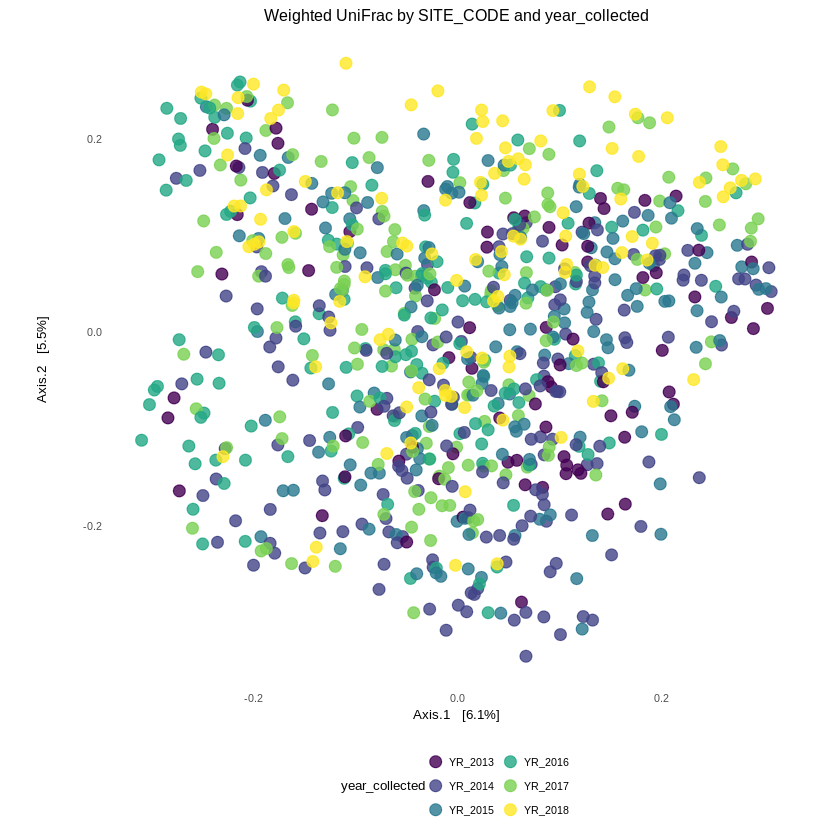

png 
  2

png 
  2

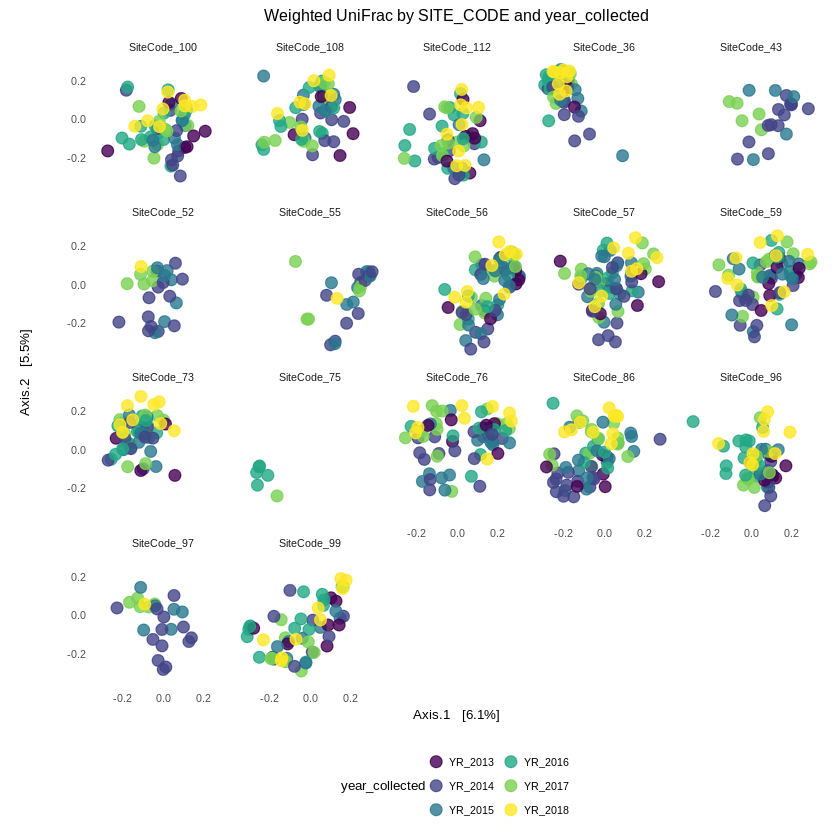

In [110]:
library(viridis)

p = plot_ordination(ps.t, ps.dist.log, color = "year_coll.factor") + #, shape = "SampleType", label="X.SampleID") + 
    ggtitle("Weighted UniFrac by SITE_CODE and year_collected") +
    geom_point(size=3, alpha=0.8) + 
    scale_colour_viridis(option="viridis", discrete=TRUE, direction=1) +
    #stat_ellipse(level=0.95, geom="polygon",alpha = .2, aes(fill = year_collected), linetype=0) +
    #scale_fill_viridis(option="viridis", discrete=FALSE, direction=1)+
    coord_fixed(sqrt(ps.dist.evals[2] / ps.dist.evals[1]))

p = p + guides(colour = guide_legend(title = "year_collected", ncol = 2, keywidth = 1, keyheight = 1))

p = p + theme_minimal() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=8, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.ticks = element_blank(),
              legend.key.size = unit(.1, "in"),
              legend.spacing.x = unit(.01,"in"),
              legend.position = "bottom",
              plot.title = element_text(hjust = 0.5))

p$layers <- p$layers[-1]

p

p2 = p + facet_wrap(~SITE_CODE.factor)

p2

png('/home/holutz/Temp/ShoKodera/wunifrac/wunif_by_year.png', width=8, height=8, units='in', res=500)
plot(p)
dev.off()

png('/home/holutz/Temp/ShoKodera/wunifrac/wunif_by_sitecode.facet.png', width=8, height=8, units='in', res=500)
plot(p2)
dev.off()

#### Subsetting by SITE_CODE

I am not sure which is more appropriate, the above approach or estimating these values for each site independently...

In [99]:
#Subset by SITE_CODE
Site36 = subset_samples(ps.t, SITE_CODE.factor=="SiteCode_36")
Site43 = subset_samples(ps.t, SITE_CODE.factor=="SiteCode_43")
Site52 = subset_samples(ps.t, SITE_CODE.factor=="SiteCode_52")
Site55 = subset_samples(ps.t, SITE_CODE.factor=="SiteCode_55")
Site56 = subset_samples(ps.t, SITE_CODE.factor=="SiteCode_56")
Site57 = subset_samples(ps.t, SITE_CODE.factor=="SiteCode_57")
Site59 = subset_samples(ps.t, SITE_CODE.factor=="SiteCode_59")
Site73 = subset_samples(ps.t, SITE_CODE.factor=="SiteCode_73")
Site75 = subset_samples(ps.t, SITE_CODE.factor=="SiteCode_75")
Site76 = subset_samples(ps.t, SITE_CODE.factor=="SiteCode_76")
Site86 = subset_samples(ps.t, SITE_CODE.factor=="SiteCode_86")
Site96 = subset_samples(ps.t, SITE_CODE.factor=="SiteCode_96")
Site97 = subset_samples(ps.t, SITE_CODE.factor=="SiteCode_97")
Site99 = subset_samples(ps.t, SITE_CODE.factor=="SiteCode_99")
Site100 = subset_samples(ps.t, SITE_CODE.factor=="SiteCode_100")
Site108 = subset_samples(ps.t, SITE_CODE.factor=="SiteCode_108")
Site112 = subset_samples(ps.t, SITE_CODE.factor=="SiteCode_112")

In [100]:
#SiteCode_36
Site36.dist = distance(Site36, method = "wunifrac", type = "samples")
Site36.dist.log = ordinate(Site36, method = "PCoA", distance = "wunifrac")
Site36.dist.evals = Site36.dist.log$values$Eigenvalues
#SiteCode_43
Site43.dist = distance(Site43, method = "wunifrac", type = "samples")
Site43.dist.log = ordinate(Site43, method = "PCoA", distance = "wunifrac")
Site43.dist.evals = Site43.dist.log$values$Eigenvalues
#SiteCode_52
Site52.dist = distance(Site52, method = "wunifrac", type = "samples")
Site52.dist.log = ordinate(Site52, method = "PCoA", distance = "wunifrac")
Site52.dist.evals = Site52.dist.log$values$Eigenvalues
#SiteCode_55
Site55.dist = distance(Site55, method = "wunifrac", type = "samples")
Site55.dist.log = ordinate(Site55, method = "PCoA", distance = "wunifrac")
Site55.dist.evals = Site55.dist.log$values$Eigenvalues
#SiteCode_57
Site57.dist = distance(Site57, method = "wunifrac", type = "samples")
Site57.dist.log = ordinate(Site57, method = "PCoA", distance = "wunifrac")
Site57.dist.evals = Site57.dist.log$values$Eigenvalues
#SiteCode_59
Site59.dist = distance(Site59, method = "wunifrac", type = "samples")
Site59.dist.log = ordinate(Site59, method = "PCoA", distance = "wunifrac")
Site59.dist.evals = Site59.dist.log$values$Eigenvalues
#SiteCode_73
Site73.dist = distance(Site73, method = "wunifrac", type = "samples")
Site73.dist.log = ordinate(Site73, method = "PCoA", distance = "wunifrac")
Site73.dist.evals = Site73.dist.log$values$Eigenvalues
#SiteCode_75
Site75.dist = distance(Site75, method = "wunifrac", type = "samples")
Site75.dist.log = ordinate(Site75, method = "PCoA", distance = "wunifrac")
Site75.dist.evals = Site75.dist.log$values$Eigenvalues
#SiteCode_76
Site76.dist = distance(Site76, method = "wunifrac", type = "samples")
Site76.dist.log = ordinate(Site76, method = "PCoA", distance = "wunifrac")
Site76.dist.evals = Site76.dist.log$values$Eigenvalues
#SiteCode_86
Site86.dist = distance(Site86, method = "wunifrac", type = "samples")
Site86.dist.log = ordinate(Site86, method = "PCoA", distance = "wunifrac")
Site86.dist.evals = Site86.dist.log$values$Eigenvalues
#SiteCode_96
Site96.dist = distance(Site96, method = "wunifrac", type = "samples")
Site96.dist.log = ordinate(Site96, method = "PCoA", distance = "wunifrac")
Site96.dist.evals = Site96.dist.log$values$Eigenvalues
#SiteCode_97
Site97.dist = distance(Site97, method = "wunifrac", type = "samples")
Site97.dist.log = ordinate(Site97, method = "PCoA", distance = "wunifrac")
Site97.dist.evals = Site97.dist.log$values$Eigenvalues
#SiteCode_99
Site99.dist = distance(Site99, method = "wunifrac", type = "samples")
Site99.dist.log = ordinate(Site99, method = "PCoA", distance = "wunifrac")
Site99.dist.evals = Site99.dist.log$values$Eigenvalues
#SiteCode_100
Site100.dist = distance(Site100, method = "wunifrac", type = "samples")
Site100.dist.log = ordinate(Site100, method = "PCoA", distance = "wunifrac")
Site100.dist.evals = Site100.dist.log$values$Eigenvalues
#SiteCode_108
Site108.dist = distance(Site108, method = "wunifrac", type = "samples")
Site108.dist.log = ordinate(Site108, method = "PCoA", distance = "wunifrac")
Site108.dist.evals = Site108.dist.log$values$Eigenvalues
#SiteCode_112
Site112.dist = distance(Site112, method = "wunifrac", type = "samples")
Site112.dist.log = ordinate(Site112, method = "PCoA", distance = "wunifrac")
Site112.dist.evals = Site112.dist.log$values$Eigenvalues

Warning message in UniFrac(physeq, weighted = TRUE, ...):
“Randomly assigning root as -- GACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGTTTTCCAAGTTGGGTGTGAAAGCCTTGGGCTTAACCCAAGAAATG -- in the phylogenetic tree in the data you provided.”
Warning message in UniFrac(physeq, weighted = TRUE, ...):
“Randomly assigning root as -- TACGAAGGATCCAAGCGTTATCCGGAATCATTGGGTTTAAAGGGTCCGTAGGCGGTTTAGTAAGTCAGTGGTGAAAGCCCATCGCTCAACGGTGGAACGG -- in the phylogenetic tree in the data you provided.”
Warning message in UniFrac(physeq, weighted = TRUE, ...):
“Randomly assigning root as -- GACGAACCGTGCAAACGTTATTCGGAATCACTGGGCATAAAGGGCGCGTAGGCGGCTTGACAAGTCAGGGGTGAAATCCGGCAGCTTAACTGTCGCAGTG -- in the phylogenetic tree in the data you provided.”
Warning message in UniFrac(physeq, weighted = TRUE, ...):
“Randomly assigning root as -- GACGAACCGCACAAACGTTATTCGGAATCACTGGGCTTAAAGGGTGCGTAGGCGGTCCGGAAAGTTGGGTGTGAAATCCCTCGGCTCAACCGAGGAACTG -- in the phylogenetic tree in the data you provided.”
Warning message in U

#### Plotting individual results per site

png 
  2

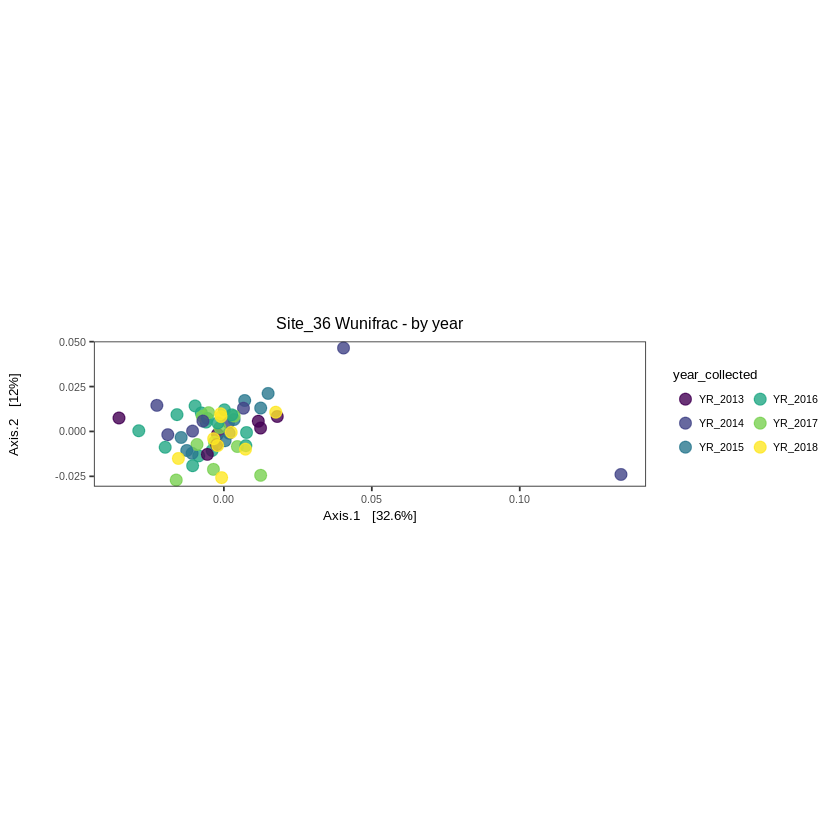

In [106]:
library(viridis)

p = plot_ordination(Site36, Site36.dist.log, color = "year_coll.factor") + #, shape = "SampleType", label="X.SampleID") + 
    ggtitle("Site_36 Wunifrac - by year") +
    geom_point(size=3, alpha=0.8) + 
    scale_colour_viridis(option="viridis", discrete=TRUE, direction=1) +
    #stat_ellipse(level=0.95, geom="polygon",alpha = .2, aes(fill = year_coll.factor), linetype=0) +
    #scale_fill_viridis(option="viridis", discrete=TRUE, direction=1)+
    coord_fixed(sqrt(Site36.dist.evals[2] / Site36.dist.evals[1]))

p = p + guides(colour = guide_legend(title = "year_collected", ncol = 2, keywidth = 1, keyheight = 1))

p = p + theme_bw() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=8, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.ticks = element_blank(),
              legend.key.size = unit(.1, "in"),
              legend.spacing.x = unit(.01,"in"),
              legend.position = "right",
              plot.title = element_text(hjust = 0.5))

p$layers <- p$layers[-1]

#p = p + facet_wrap(~year_collected)

p

png('/home/holutz/Temp/ShoKodera/wunifrac/PerSitePCoA/Site_36.wuf.pcoa.png', width=8, height=8, units='in', res=500)
plot(p)
dev.off()